# DCBC model evaluation

In [2]:
import ProbabilisticParcellation.evaluate_existing as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import os

## Produce or load results:

In [3]:
rerun_results=False
max_dist=40

if rerun_results:
    test_datasets_list = [0,1,2,3,4,5,6,7]
    T = pd.read_csv(ut.base_dir + '/dataset_description.tsv', sep='\t')
    num_subj = T.return_nsubj.to_numpy()[test_datasets_list]
    types = T.default_type.to_numpy()[test_datasets_list]
    existing_atlasses = ['Anatom', 'Buckner7', 'Buckner17', 'Ji10', 'MDTB10']
    fusion_atlasses = ['NettekovenAsym68', 'NettekovenSym68']

    Data = ev.eval_atlas(fusion_atlasses + existing_atlasses,
                t_datasets=T.name.to_numpy()[test_datasets_list],
                type=types, max_dist=max_dist)
    Data.to_csv(f'{ut.model_dir}/Models/Evaluation/nettekoven_68/eval_atlas_existing_dist-{max_dist}.tsv', sep='\t', index=False)
else:
    Data = pd.read_csv(f'{ut.model_dir}/Models/Evaluation/nettekoven_68/eval_atlas_existing_dist-{max_dist}.tsv', sep='\t')

# Remove HCP test data
Data = Data[Data['test_data'] != 'HCP']
Data = Data.drop(columns=['space'])
Data.head()

,atlas_name,K,subj_num,dcbc_group,test_data
0,NettekovenAsym68,64,0,0.091580,MDTB
1,NettekovenAsym68,64,1,0.071558,MDTB
2,NettekovenAsym68,64,2,0.046350,MDTB
3,NettekovenAsym68,64,3,0.176457,MDTB
4,NettekovenAsym68,64,4,0.093350,MDTB


In [4]:
# Formula for calculating statistics
def print_ttest(x,y, paired=False):
    
    if paired:
        result = stats.ttest_rel(x,y)
        df= len(x) - 1
    else:
        result = stats.ttest_ind(x,y)
        df= len(x) + len(y) - 2
    
    # Print results formatted with p-value rounded to 3rd decimal if larger than 0.001, otherwise scientific notation
    if result[1] < 0.001:
        print(f't({df}) = {result[0]:.3f}, p = {result[1]:.3e}')
    else:
        print(f't({df}) = {result[0]:.3f}, p = {result[1]:.3f}')
    print(f'x = {np.mean(x):.5f} +/- {np.std(x):.3f}, y = {np.mean(y):.5f} +/- {np.std(y):.3f}')

## Plots

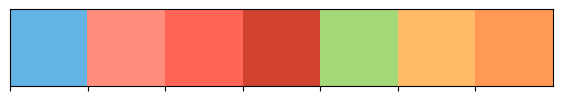

In [5]:
atlas_order = ['Anatom', 'Buckner7', 'Ji10', 'Buckner17', 'MDTB10', 'NettekovenSym68', 'NettekovenAsym68']
# Order atlas_name column by atlas_order
Data['atlas_name'] = pd.Categorical(Data['atlas_name'], atlas_order)

# -- Colour palette --
# Define the base color palette with 9 colors, grouped by atlas type:
# anatomical (blue), resting-state (3 shades of red), MDTB (green), and Nettekoven (4 shades of orange)
base_palette = [
    "#63B4E5",  # Light Blue
    "#FF8D7F",  # Light Red
    "#FF6554",  # Medium Red
    "#D14231",  # Dark Red
    "#A2D876",  # Light Green
    "#FFBB68",  # Light Orange
    "#FF9953",  # Medium Orange
    # "#FF7B3B",  # Dark Orange
    # "#FF5E1A"   # Deep Orange
]

# Create a cpalette
color_palette = sb.color_palette(base_palette)

# Display the color palette
sb.palplot(color_palette)


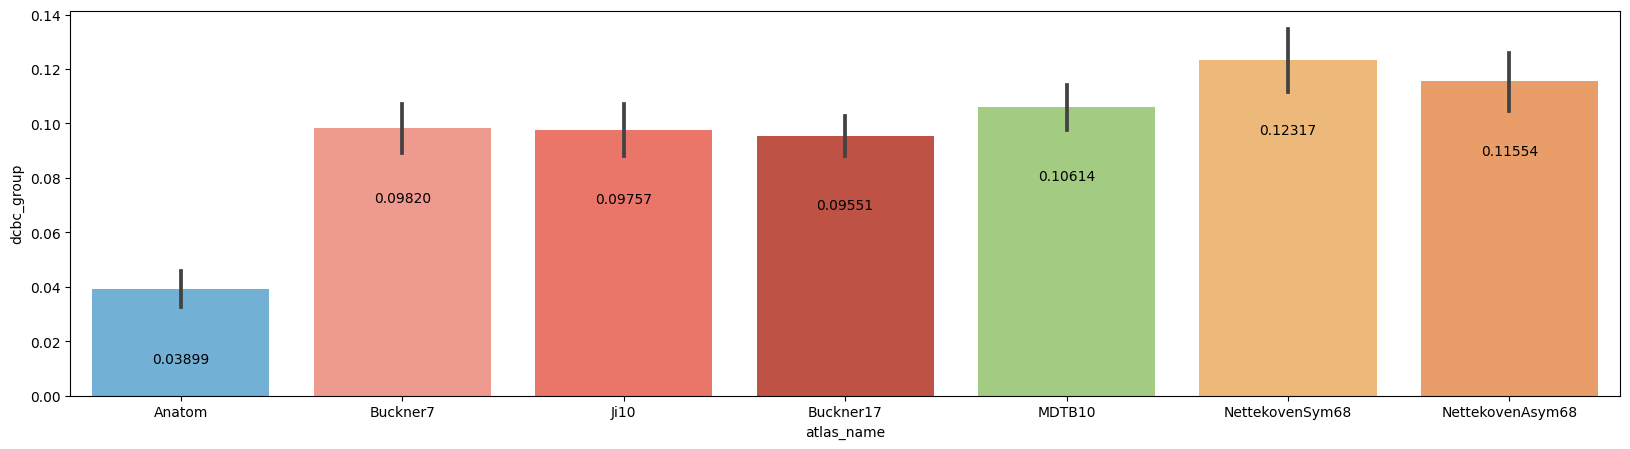

In [6]:
plt.figure(figsize=(20, 5))
ax = sb.barplot(data=Data, x='atlas_name', y='dcbc_group', palette=color_palette)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.5f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, -50), textcoords='offset points')

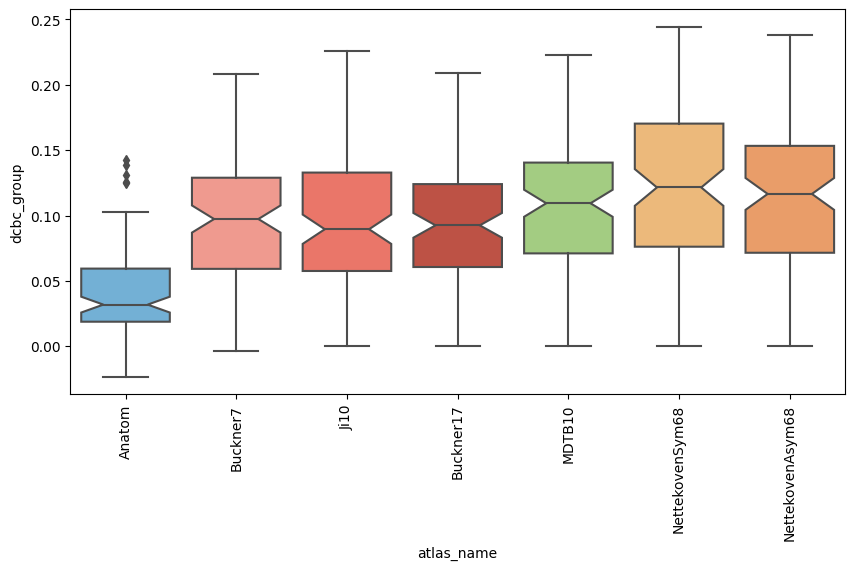

In [8]:
plt.figure(figsize=(10,5))
ax = sb.boxplot(data=Data, x='atlas_name', y='dcbc_group', palette=color_palette, notch=True)
# Rotate labels 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)   
plt.savefig(f'{ut.figure_dir}/eval_atlas_existing_dist-{max_dist}_dcbc_group_alternative.pdf', dpi=300, bbox_inches='tight')



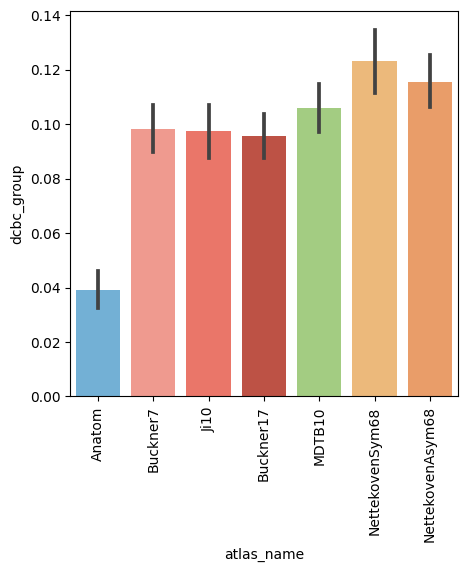

In [10]:
plt.figure(figsize=(5,5))
ax = sb.barplot(data=Data, x='atlas_name', y='dcbc_group', palette=color_palette)
# Rotate labels 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)   
plt.savefig(f'{ut.figure_dir}/eval_atlas_existing_dist-{max_dist}_dcbc_group.pdf', dpi=300, bbox_inches='tight')



In [12]:
Data.drop(columns=['test_data']).groupby('atlas_name').mean().reset_index().sort_values(by='dcbc_group', ascending=False)

,atlas_name,K,subj_num,dcbc_group
5,NettekovenSym68,61.0,10.801802,0.123167
6,NettekovenAsym68,64.0,10.801802,0.115538
4,MDTB10,149.0,10.801802,0.106141
1,Buckner7,83.0,10.801802,0.098202
2,Ji10,573.0,10.801802,0.097565
3,Buckner17,149.0,10.801802,0.095514
0,Anatom,44.0,10.801802,0.038991


## MDTB 10 vs Nettekoven atlasses

### paired t-test between each subject's DCBC for MDTB10 and Nettekoven atlas

In [13]:
for new_atlas in ['NettekovenSym68', 'NettekovenAsym68']:
    x = Data[(Data['atlas_name'] == new_atlas)]['dcbc_group']
    y = Data[(Data['atlas_name'] == 'MDTB10')]['dcbc_group']
    print(f'\n{new_atlas} vs MDTB10')
    print_ttest(x,y, paired=True)

    


NettekovenSym68 vs MDTB10
t(110) = 5.364, p = 4.554e-07
x = 0.12317 +/- 0.060, y = 0.10614 +/- 0.046

NettekovenAsym68 vs MDTB10
t(110) = 3.545, p = 5.788e-04
x = 0.11554 +/- 0.053, y = 0.10614 +/- 0.046


## Buckner7 vs Nettekoven atlasses

In [14]:
for new_atlas in ['NettekovenSym68', 'NettekovenAsym68']:
    x = Data[(Data['atlas_name'] == new_atlas)]['dcbc_group']
    y = Data[(Data['atlas_name'] == 'Buckner7')]['dcbc_group']
    print(f'\n{new_atlas} vs Buckner7')
    print_ttest(x,y, paired=True)

    


NettekovenSym68 vs Buckner7
t(110) = 6.975, p = 2.409e-10
x = 0.12317 +/- 0.060, y = 0.09820 +/- 0.047

NettekovenAsym68 vs Buckner7
t(110) = 4.690, p = 7.882e-06
x = 0.11554 +/- 0.053, y = 0.09820 +/- 0.047


## Buckner17 vs Nettekoven atlasses

In [15]:
for new_atlas in ['NettekovenSym68', 'NettekovenAsym68']:
    x = Data[(Data['atlas_name'] == new_atlas)]['dcbc_group']
    y = Data[(Data['atlas_name'] == 'Buckner17')]['dcbc_group']
    print(f'\n{new_atlas} vs Buckner17')
    print_ttest(x,y, paired=True)

    


NettekovenSym68 vs Buckner17
t(110) = 7.954, p = 1.739e-12
x = 0.12317 +/- 0.060, y = 0.09551 +/- 0.042

NettekovenAsym68 vs Buckner17
t(110) = 6.017, p = 2.374e-08
x = 0.11554 +/- 0.053, y = 0.09551 +/- 0.042


## Ji10 vs Nettekoven atlasses

In [16]:
for new_atlas in ['NettekovenSym68', 'NettekovenAsym68']:
    x = Data[(Data['atlas_name'] == new_atlas)]['dcbc_group']
    y = Data[(Data['atlas_name'] == 'Ji10')]['dcbc_group']
    print(f'\n{new_atlas} vs Ji10')
    print_ttest(x,y, paired=True)

    


NettekovenSym68 vs Ji10
t(110) = 6.988, p = 2.249e-10
x = 0.12317 +/- 0.060, y = 0.09757 +/- 0.051

NettekovenAsym68 vs Ji10
t(110) = 4.640, p = 9.683e-06
x = 0.11554 +/- 0.053, y = 0.09757 +/- 0.051


## Anatomical vs Nettekoven atlasses

In [17]:
for new_atlas in ['NettekovenSym68', 'NettekovenAsym68']:
    x = Data[(Data['atlas_name'] == new_atlas)]['dcbc_group']
    y = Data[(Data['atlas_name'] == 'Anatom')]['dcbc_group']
    print(f'\n{new_atlas} vs Anatom')
    print_ttest(x,y, paired=True)

    


NettekovenSym68 vs Anatom
t(110) = 13.553, p = 3.338e-25
x = 0.12317 +/- 0.060, y = 0.03899 +/- 0.035

NettekovenAsym68 vs Anatom
t(110) = 14.191, p = 1.315e-26
x = 0.11554 +/- 0.053, y = 0.03899 +/- 0.035


<Axes: xlabel='test_data', ylabel='dcbc_group'>

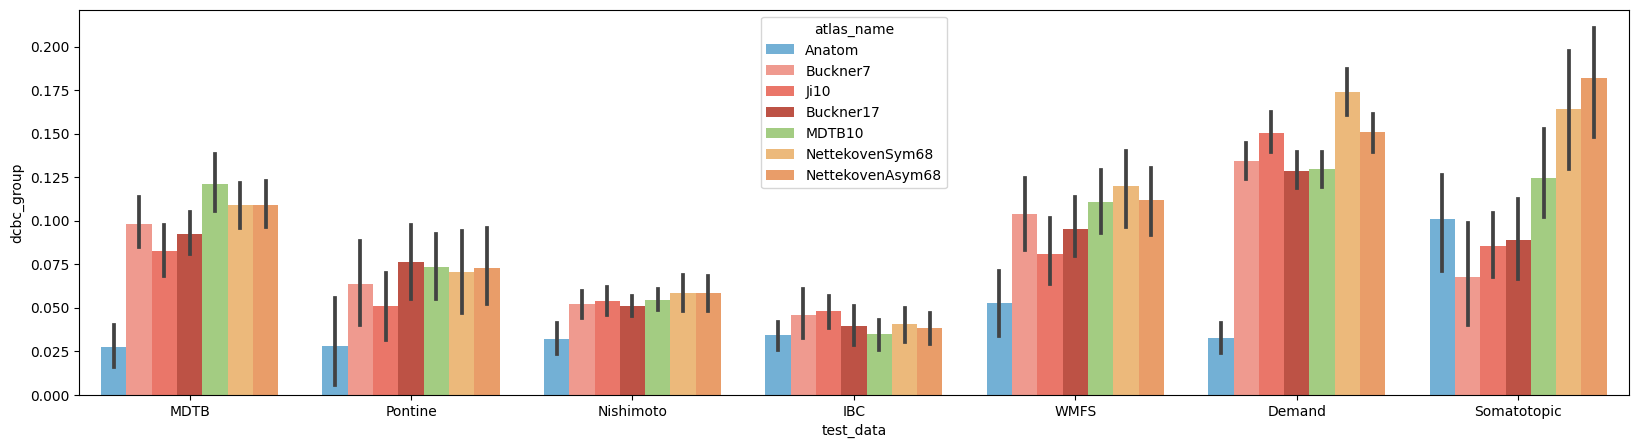

In [18]:
plt.figure(figsize=(20, 5))
sb.barplot(data=Data, x='test_data', y='dcbc_group', hue='atlas_name', palette=color_palette)



# Average within dataset

In [19]:
Data_mean = Data.groupby(['atlas_name', 'test_data']).mean().reset_index()
Data_mean.head()


,atlas_name,test_data,K,subj_num,dcbc_group
0,Anatom,Demand,44.0,18.0,0.032431
1,Anatom,IBC,44.0,5.5,0.034078
2,Anatom,MDTB,44.0,11.5,0.027264
3,Anatom,Nishimoto,44.0,2.5,0.031941
4,Anatom,Pontine,44.0,3.5,0.028204


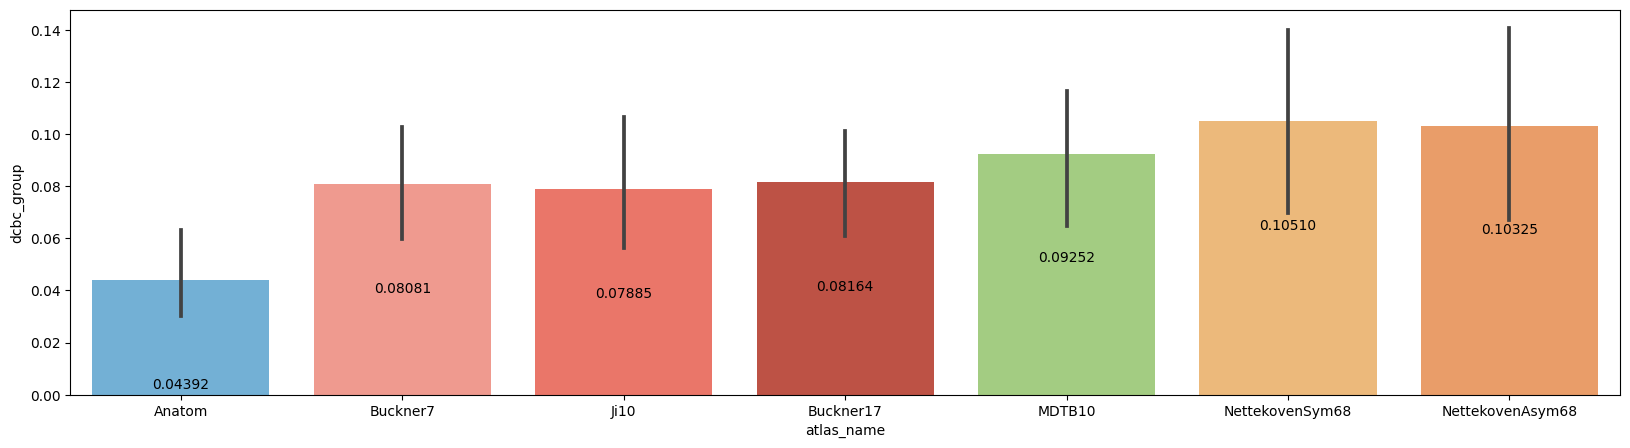

In [20]:
plt.figure(figsize=(20, 5))
ax = sb.barplot(data=Data_mean, x='atlas_name', y='dcbc_group', palette=color_palette)
# Print the mean value of each bar above the bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.5f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, -75), textcoords='offset points')

In [21]:
Data_mean.drop(columns=['test_data']).groupby('atlas_name').mean().reset_index().sort_values(by='dcbc_group', ascending=False)



,atlas_name,K,subj_num,dcbc_group
5,NettekovenSym68,61.0,7.428571,0.105095
6,NettekovenAsym68,64.0,7.428571,0.103250
4,MDTB10,149.0,7.428571,0.092517
3,Buckner17,149.0,7.428571,0.081645
1,Buckner7,83.0,7.428571,0.080810
2,Ji10,573.0,7.428571,0.078847
0,Anatom,44.0,7.428571,0.043920


### paired t-test between each test dataset's average DCBC for MDTB10 and Nettekoven atlas

In [22]:
for new_atlas in ['NettekovenSym68', 'NettekovenAsym68']:
    x = Data_mean[(Data_mean['atlas_name'] == new_atlas)]['dcbc_group']
    y = Data_mean[(Data_mean['atlas_name'] == 'MDTB10')]['dcbc_group']
    print(f'\n{new_atlas} vs MDTB10')
    print_ttest(x,y, paired=True)

    


NettekovenSym68 vs MDTB10
t(6) = 1.554, p = 0.171
x = 0.10510 +/- 0.048, y = 0.09252 +/- 0.035

NettekovenAsym68 vs MDTB10
t(6) = 1.239, p = 0.262
x = 0.10325 +/- 0.047, y = 0.09252 +/- 0.035
